# GRU with Multiple Word Embeddings

Team Member: Oreste Abizera
Model: GRU (Gated Recurrent Unit)
Embedding: TF-IDF, Word2Vec (Skip-gram), CBOW

## 1. Setup & Imports

In [6]:
!pip install gensim

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Embedding, Dropout, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from gensim.models import Word2Vec


try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


sns.set(style="whitegrid")
RANDOM_STATE = 42
MAX_SEQ_LEN = 200
EMBEDDING_DIM = 100
GRU_UNITS = 128
EPOCHS = 15
BATCH_SIZE = 64

## 2. Load Data

In [8]:
DATA_PATH = '../data/IMDB Dataset.csv'
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
    DATA_PATH = '/content/drive/MyDrive/ml-imdb-project/data/IMDB Dataset.csv'
except ImportError:
        print("Warning: google.colab not available. Falling back to local paths.")
if not os.path.exists(DATA_PATH):
    print(f"Warning: {DATA_PATH} not found. Please ensure the dataset is in the data folder.")
else:
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded successfully: {df.shape}")
    display(df.head())

Mounted at /content/drive
Google Drive mounted successfully!
Dataset loaded successfully: (50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Exploratory Data Analysis (EDA)
Understanding the dataset characteristics.

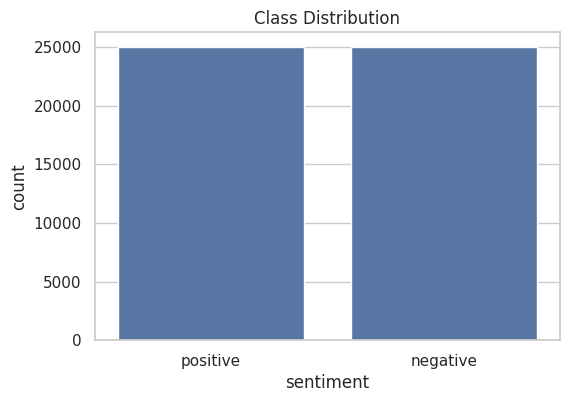

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [9]:
if 'sentiment' in df.columns:
    # Class Distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df)
    plt.title('Class Distribution')
    plt.show()
    print(df['sentiment'].value_counts())

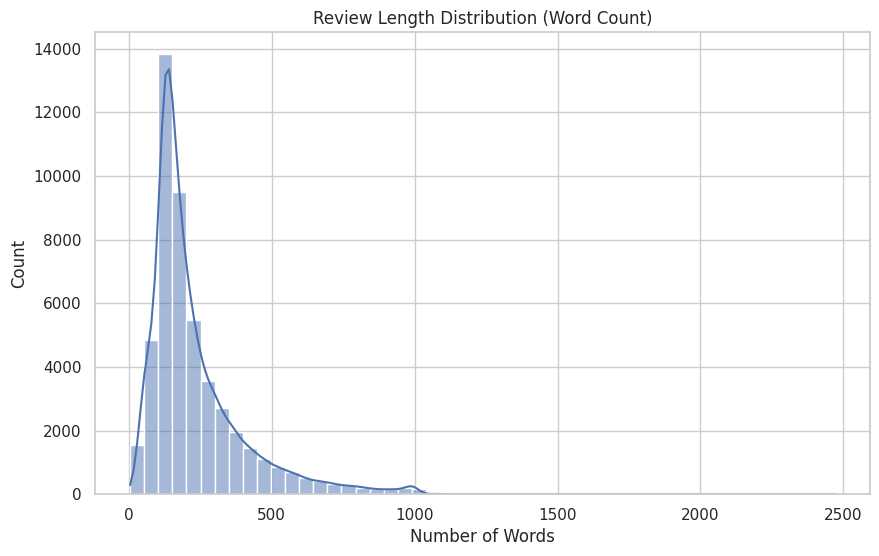

Average word count: 231.16


In [10]:
# Review Length Analysis
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Review Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.show()

print(f"Average word count: {df['word_count'].mean():.2f}")

## 4. Preprocessing
Applying shared preprocessing strategy:
1. Lowercase
2. Remove HTML tags
3. Remove special characters
4. Tokenize
5. Remove stopwords (Optional based on embedding)

In [11]:
def clean_text(text, remove_stopwords=True):
    # 1. Lowercase
    text = text.lower()
    # 2. HTML tag removal
    text = re.sub(r'<.*?>', '', text)
    # 3. Remove non-alphanumeric characters (preserving spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Tokenize
    tokens = word_tokenize(text)

    # 5. Remove stopwords (Optional based on embedding)
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [w for w in tokens if w not in stop_words]
        return " ".join(filtered_tokens)
    else:
        return " ".join(tokens)

# Apply cleaning (Default strategy)
print("Preprocessing data (this may take a moment)...")
df['cleaned_review'] = df['review'].apply(lambda x: clean_text(x, remove_stopwords=True))
display(df[['review', 'cleaned_review']].head())

Preprocessing data (this may take a moment)...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically theres family little boy jake thinks...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...


### Post-Preprocessing Visualization

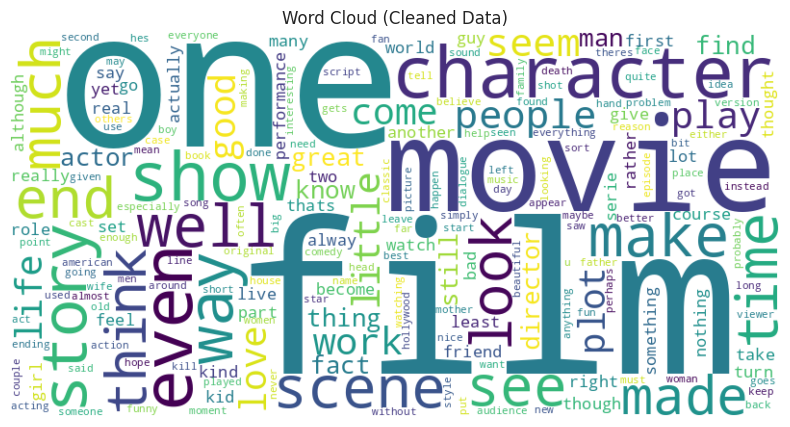

In [12]:
# Word Cloud for cleaned text
all_text = " ".join(df['cleaned_review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Data)')
plt.show()

In [13]:
# Train/Test Split
X = df['cleaned_review'].values
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values # Binary encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 40000
Testing samples: 10000


## 5. Embedding Layer & GRU Training
Preprocessing is adapted per embedding:
- **TF-IDF:** Uses shared preprocessing with stopword removal. Documents are vectorized with `TfidfVectorizer(max_features=500)` and reshaped to sequences for GRU.
- **Skip-gram / CBOW:** Uses tokenized text without stopword removal to preserve context for Word2Vec. Tokenizer and padded sequences are built from the same tokenization; embedding matrices are filled from trained Word2Vec (Skip-gram: `sg=1`, CBOW: `sg=0`).

In [14]:
# Prepare tokenized sentences for Word2Vec (Skip-gram and CBOW).
# For Word2Vec we use preprocessing without stopword removal to preserve context (common practice).
def get_tokenized_sentences(texts):
    return [clean_text(t, remove_stopwords=False).split() for t in texts]

def build_sequences_and_embedding_matrix(X_train_tok, X_test_tok, w2v_model, max_seq_len=MAX_SEQ_LEN, embedding_dim=EMBEDDING_DIM):
    """Build tokenizer, padded sequences, and embedding matrix from tokenized texts and a Word2Vec model."""
    tokenizer = Tokenizer(oov_token='<OOV>')
    tokenizer.fit_on_texts([' '.join(s) for s in X_train_tok])
    vocab_size = len(tokenizer.word_index) + 1

    X_train_seq = pad_sequences(
        tokenizer.texts_to_sequences([' '.join(s) for s in X_train_tok]),
        maxlen=max_seq_len, padding='post', truncating='post'
    )
    X_test_seq = pad_sequences(
        tokenizer.texts_to_sequences([' '.join(s) for s in X_test_tok]),
        maxlen=max_seq_len, padding='post', truncating='post'
    )

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if i < vocab_size and word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

    return tokenizer, X_train_seq, X_test_seq, embedding_matrix, vocab_size

def compute_metrics(y_true, y_pred):
    """Compute Accuracy, Precision, Recall, and F1 for binary classification."""
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='binary', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='binary', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='binary', zero_division=0),
    }

X_train_tok = get_tokenized_sentences(X_train)
X_test_tok = get_tokenized_sentences(X_test)

# Store results for comparative analysis
results_list = []

In [15]:
# --- 1. GRU with TF-IDF ---
# Preprocessing for TF-IDF: use cleaned text (stopwords removed). GRU receives document as sequence of feature dimensions.
clear_session()
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1, 1), min_df=2, max_df=0.95)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()
# Reshape for GRU: (samples, timesteps, features) -> each document is one "sequence" of 500 TF-IDF values
X_train_tfidf_seq = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf_seq = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

model_tfidf = Sequential([
    Bidirectional(GRU(GRU_UNITS, return_sequences=False), input_shape=(X_train_tfidf_seq.shape[1], 1)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_tfidf = model_tfidf.fit(X_train_tfidf_seq, y_train, validation_data=(X_test_tfidf_seq, y_test),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_tfidf = (model_tfidf.predict(X_test_tfidf_seq) > 0.5).astype(int).flatten()
metrics_tfidf = compute_metrics(y_test, y_pred_tfidf)
results_list.append({'embedding': 'TF-IDF', **metrics_tfidf})
print(f"TF-IDF — Accuracy: {metrics_tfidf['accuracy']:.4f}, Precision: {metrics_tfidf['precision']:.4f}, Recall: {metrics_tfidf['recall']:.4f}, F1: {metrics_tfidf['f1']:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 39ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.5272 - val_loss: 0.6914
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5257 - loss: 0.6910 - val_accuracy: 0.5463 - val_loss: 0.6821
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5724 - loss: 0.6747 - val_accuracy: 0.5965 - val_loss: 0.6672
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5893 - loss: 0.6689 - val_accuracy: 0.5662 - val_loss: 0.6822
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5611 - loss: 0.6928 - val_accuracy: 0.5844 - val_loss: 0.6709
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.5792 - loss: 0.6741 - val_accuracy: 0.5962 - val_loss: 0.6657
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 40ms/step - accuracy: 0.5855 - loss: 0.6687 - val_accuracy: 0.5872 - val_loss: 0.6668
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.5894 - loss: 0.6666 - 

In [16]:
# --- 2. GRU with Skip-gram (Word2Vec) ---
# Skip-gram: sg=1. Train on tokenized training corpus only.
clear_session()
w2v_skip = Word2Vec(sentences=X_train_tok, vector_size=EMBEDDING_DIM, window=5, min_count=2, sg=1, epochs=10, seed=RANDOM_STATE, workers=1)
_, X_train_seq_skip, X_test_seq_skip, embedding_matrix_skip, vocab_size_skip = build_sequences_and_embedding_matrix(
    X_train_tok, X_test_tok, w2v_skip
)

model_skip = Sequential([
    Embedding(vocab_size_skip, EMBEDDING_DIM, weights=[embedding_matrix_skip], input_length=MAX_SEQ_LEN, trainable=True),
    Bidirectional(GRU(GRU_UNITS, return_sequences=False)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model_skip.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_skip = model_skip.fit(X_train_seq_skip, y_train, validation_data=(X_test_seq_skip, y_test),
                               epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_skip = (model_skip.predict(X_test_seq_skip) > 0.5).astype(int).flatten()
metrics_skip = compute_metrics(y_test, y_pred_skip)
results_list.append({'embedding': 'Skip-gram', **metrics_skip})
print(f"Skip-gram — Accuracy: {metrics_skip['accuracy']:.4f}, Precision: {metrics_skip['precision']:.4f}, Recall: {metrics_skip['recall']:.4f}, F1: {metrics_skip['f1']:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.7602 - loss: 0.4759 - val_accuracy: 0.8896 - val_loss: 0.2727
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9361 - loss: 0.1765 - val_accuracy: 0.9032 - val_loss: 0.2401
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9832 - loss: 0.0578 - val_accuracy: 0.8813 - val_loss: 0.3164
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9969 - loss: 0.0114 - val_accuracy: 0.8855 - val_loss: 0.6030
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.8814 - val_loss: 0.4459
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9997 - loss: 0.0016 - val_accuracy: 0.8789 - val_loss: 0.6988
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.8812 - val_loss: 0.7122
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 1.0000 - loss: 1.5849e-0

In [17]:
# --- 3. GRU with CBOW (Word2Vec) ---
# CBOW: sg=0. Same tokenization and sequence preparation as Skip-gram.
clear_session()
w2v_cbow = Word2Vec(sentences=X_train_tok, vector_size=EMBEDDING_DIM, window=5, min_count=2, sg=0, seed=RANDOM_STATE, workers=1)
_, X_train_seq_cbow, X_test_seq_cbow, embedding_matrix_cbow, vocab_size_cbow = build_sequences_and_embedding_matrix(
    X_train_tok, X_test_tok, w2v_cbow
)

model_cbow = Sequential([
    Embedding(vocab_size_cbow, EMBEDDING_DIM, weights=[embedding_matrix_cbow], input_length=MAX_SEQ_LEN, trainable=True),
    GRU(GRU_UNITS, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_cbow.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cbow = model_cbow.fit(X_train_seq_cbow, y_train, validation_data=(X_test_seq_cbow, y_test),
                              epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
y_pred_cbow = (model_cbow.predict(X_test_seq_cbow) > 0.5).astype(int).flatten()
metrics_cbow = compute_metrics(y_test, y_pred_cbow)
results_list.append({'embedding': 'CBOW', **metrics_cbow})
print(f"CBOW — Accuracy: {metrics_cbow['accuracy']:.4f}, Precision: {metrics_cbow['precision']:.4f}, Recall: {metrics_cbow['recall']:.4f}, F1: {metrics_cbow['f1']:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.5236 - loss: 0.6897 - val_accuracy: 0.7650 - val_loss: 0.6180
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.5669 - loss: 0.6724 - val_accuracy: 0.7991 - val_loss: 0.4877
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.8480 - loss: 0.3649 - val_accuracy: 0.8920 - val_loss: 0.2581
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.9404 - loss: 0.1677 - val_accuracy: 0.8966 - val_loss: 0.2722
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9909 - loss: 0.0350 - val_accuracy: 0.8709 - val_loss: 0.4597
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9982 - loss: 0.0076 - val_accuracy: 0.8806 - val_loss: 0.5604
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9994 - loss: 0.0025 - val_accuracy: 0.8764 - val_loss: 0.5374
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 1.0000 - loss: 6.3719e-0

## 6. Comparison table

In [18]:

results_df = pd.DataFrame(results_list)

embedding_order = ['TF-IDF', 'Skip-gram', 'CBOW']
results_df = (
    results_df.sort_values('f1', ascending=False)
    .drop_duplicates(subset=['embedding'], keep='first')
)
results_df['embedding'] = pd.Categorical(results_df['embedding'], categories=embedding_order, ordered=True)
results_df = results_df.sort_values('embedding').reset_index(drop=True)

display(results_df)

,embedding,accuracy,precision,recall,f1
0,TF-IDF,0.6091,0.600641,0.669180,0.633061
1,Skip-gram,0.8727,0.871547,0.876563,0.874048
2,CBOW,0.8724,0.898370,0.842032,0.869289


## 7. Training Summary


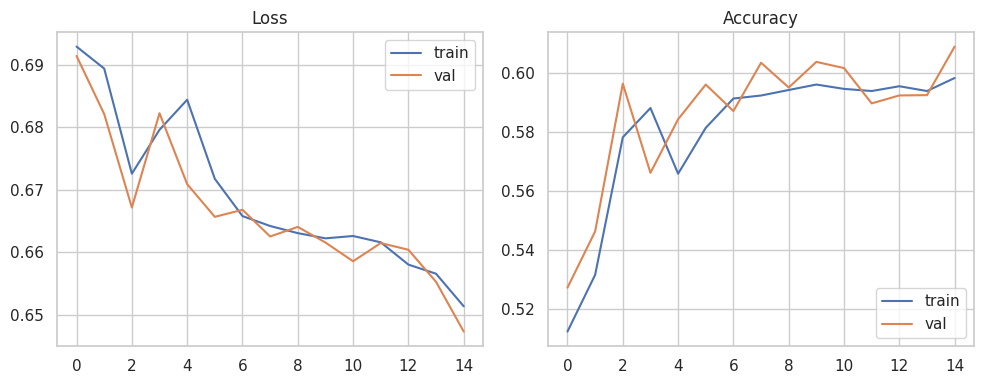

In [19]:

if 'history_tfidf' in dir():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_tfidf.history['loss'], label='train')
    plt.plot(history_tfidf.history['val_loss'], label='val')
    plt.legend(); plt.title('Loss')
    plt.subplot(1, 2, 2)
    plt.plot(history_tfidf.history['accuracy'], label='train')
    plt.plot(history_tfidf.history['val_accuracy'], label='val')
    plt.legend(); plt.title('Accuracy')
    plt.tight_layout(); plt.show()

## 8.  Comparison Table

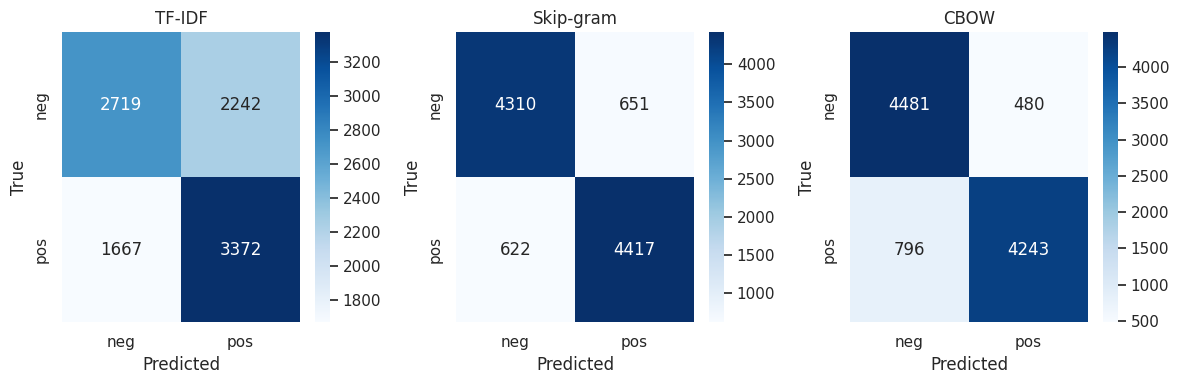

Evaluation metrics (Accuracy, Precision, Recall, F1):
embedding  accuracy  precision   recall       f1
   TF-IDF    0.6091   0.600641 0.669180 0.633061
Skip-gram    0.8727   0.871547 0.876563 0.874048
     CBOW    0.8724   0.898370 0.842032 0.869289


In [20]:
# Confusion matrices for each embedding
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
preds = [y_pred_tfidf, y_pred_skip, y_pred_cbow]
names = ['TF-IDF', 'Skip-gram', 'CBOW']
for ax, y_pred, name in zip(axes, preds, names):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=['neg', 'pos'], yticklabels=['neg', 'pos'])
    ax.set_xlabel('Predicted'); ax.set_ylabel('True'); ax.set_title(name)
plt.tight_layout(); plt.show()

# Evaluation metrics: Accuracy, Precision, Recall, F1 — comparison across embeddings
print("Evaluation metrics (Accuracy, Precision, Recall, F1):")
print(results_df.to_string(index=False))